## Jose Cruz

## Sang Choi

## Data Minor 

## Data Mining Classification Algorithms

In [1]:
import numpy as np
import math
from pprint import pprint
import time

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing


# Heart Failure Clinical Records Dataset

**Y value count**

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
X = df.drop(columns='DEATH_EVENT', axis=1)
Y = df['DEATH_EVENT']
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

**Columns**

In [3]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

**Data Overview**

In [4]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


## Decision Tree

**Our own implementation of Decision Tree algorithm**

In [5]:
def check_purity(data):
    label_column = data[:,-1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

def classify_data(data):
    label_column = data[:,-1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    return classification

def get_potential_splits(data):
    potential_splits = {}
    _, n_columns = data.shape
    
    for column_index in range(n_columns - 1):
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)
        #potential_splits[column_index] = unique_values
        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2
                
                potential_splits[column_index].append(potential_split)        
    return potential_splits

def split_data(data, split_column, split_value):
    
    split_column_values = data[:,split_column]
    
    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values > split_value]

    return data_below, data_above

def calculate_entropy(data):
    label_column = data[:,-1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

def calculate_overall_entropy(data_below, data_above):
    n_data_points = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n_data_points
    p_data_above = len(data_above) / n_data_points

    overall_entropy = (p_data_below * calculate_entropy(data_below)) + (p_data_above * calculate_entropy(data_above))

    return overall_entropy

def determine_best_split(data, potential_splits):
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below,data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    return best_split_column, best_split_value

def decision_tree_algorithm(df, counter=0, min_samples = 2, max_depth=5):

    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df

    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        return classification
    else:
        counter +=1
        
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        feature_name = COLUMN_HEADERS[split_column]
        question = '{} <= {}'.format(feature_name, split_value)
        sub_tree = {question:[]}

        yes_answer = decision_tree_algorithm(data_below, counter,min_samples,max_depth)
        no_answer = decision_tree_algorithm(data_above, counter,min_samples,max_depth)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree        

def predict_example(example, tree):
    
    # tree is just a root node
    if not isinstance(tree, dict):
        return tree
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(predict_example, args=(tree,), axis=1)
    else:
        # "df.apply()"" with empty dataframe returns an empty dataframe,
        # but "predictions" should be a series instead
        predictions = pd.Series()
        
    return predictions

def calculate_accuracy(df, tree):
    predictions = make_predictions(df, tree)
    predictions_correct = predictions == df.DEATH_EVENT
    accuracy = predictions_correct.mean()
    
    return accuracy

In [6]:
kfold = KFold(n_splits=10)
dtc_accuracy_model = []
dtc_model_time = []
mydtc_accuracy_model = []
mydtc_model_time = []
for train_index, test_index in kfold.split(X):
    
    # Split train-test
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    start = int(round(time.time() * 1000))
    dtc = DecisionTreeClassifier(criterion='entropy',random_state=0,max_depth=5)
    # Train the model
    tree_model = dtc.fit(X_train, y_train)
    
    # Append to accuracy_model the accuracy of the model
    dtc_accuracy_model.append(accuracy_score(y_test, tree_model.predict(X_test), normalize=True)*100)
    time_dtc = int(round(time.time() * 1000)) - start
    dtc_model_time.append(time_dtc)

    X_train.columns = df.columns
    start = int(round(time.time() * 1000))
    tree = decision_tree_algorithm(X_train)
    mydtc_accuracy_model.append(calculate_accuracy(X_test,tree)*100)
    time_mydtc = int(round(time.time() * 1000)) - start
    mydtc_model_time.append(time_mydtc)

    diff = [(i / j)*100 for i, j in zip(mydtc_model_time,dtc_model_time)] 
results_df = pd.DataFrame()
results_df['dtc_accuracy_model'] = dtc_accuracy_model
results_df['dtc_model_time'] = dtc_model_time
results_df['mydtc_accuracy_model'] = mydtc_accuracy_model
results_df['mydtc_model_time'] = mydtc_model_time
results_df['%diff'] = diff

results_df


,dtc_accuracy_model,dtc_model_time,mydtc_accuracy_model,mydtc_model_time,%diff
0,100.0,12,80.000000,262,2183.333333
1,100.0,3,80.000000,264,8800.000000
2,100.0,4,83.333333,240,6000.000000
3,100.0,3,73.333333,264,8800.000000
4,100.0,3,83.333333,247,8233.333333
5,100.0,3,80.000000,278,9266.666667
6,100.0,4,73.333333,267,6675.000000
7,100.0,4,76.666667,258,6450.000000
8,100.0,5,80.000000,291,5820.000000
9,100.0,4,93.103448,269,6725.000000


**snapshot of decision tree**

In [7]:
tree

{'time <= 67.5': [{'platelets <= 214500.0': [1.0,
    {'platelets <= 224500.0': [{'time <= 57.0': [0.0, 1.0]},
      {'age <= 66.5': [{'creatinine_phosphokinase <= 85.5': [0.0, 1.0]},
        1.0]}]}]},
  {'serum_creatinine <= 1.55': [{'ejection_fraction <= 27.5': [{'time <= 78.5': [1.0,
        0.0]},
      {'age <= 79.0': [0.0, {'platelets <= 239000.0': [0.0, 1.0]}]}]},
    {'ejection_fraction <= 22.5': [1.0,
      {'creatinine_phosphokinase <= 72.5': [0.0,
        {'high_blood_pressure <= 0.5': [0.0, 1.0]}]}]}]}]}

## Naive Bayes

In [8]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
col_type = {'anaemia':np.bool, 'diabetes':np.bool, 
            'high_blood_pressure':np.bool, 'sex':np.bool, 
            'smoking':np.bool, 'DEATH_EVENT':np.str}

df = df.astype(col_type)
X = df.drop(columns='DEATH_EVENT', axis=1)
Y = df['DEATH_EVENT']

In [9]:
def prior_prob_categorical(nums:pd.core.series.Series):
    return nums.value_counts(normalize=True)
    
def get_std_dev(nums: pd.core.series.Series):
    mean = nums.mean()
    return (((nums - mean)**2).aggregate(np.sum)/(len(nums)-1))**0.5
# prior_prob_categorical(df['sex'])["1"]

def calculate_prob(x, mean, std):
    exponent = math.exp((-1 * (x - mean)**2)/(2*(std**2)))
    return (1 / (std * (2*math.pi)**0.5)) * exponent

assert(calculate_prob(1, 1, 1) == 0.3989422804014327)
assert(calculate_prob(2, 1, 1) == 0.24197072451914337)

def train_naive_bayes(x_train, y_train):
    # dictionary that stores all probabiltiies for categorical or mean/std for continuous data
    prob = dict()
    col_y = y_train.name
    classes = np.unique(y_train)
    df = x_train.copy()
    df[col_y] = y_train
    
    class_counts = y_train.value_counts(normalize=True)
    prob['classes'] = {cls: class_counts[cls] for cls in classes}
    
    # go through each class and calculate piori probabilities for each unique column value
    for cls in classes:
        tmp = df[df[col_y] == cls]

        for col in x_train.columns:
            col = str(col)
            if col != col_y:
                if col not in prob.keys():
                    prob[col] = dict()
                
                prob[col][cls] = dict()

                if x_train.dtypes[col] == np.bool:
                    val_probs = prior_prob_categorical(tmp[col])
                    for val in np.unique(tmp[col]):
                        try:
                            prob[col][cls][val] = val_probs[val]
                        
                        except IndexError:
                            prob[col][cls][val] = 0

                else:
                    prob[col][cls] = {
                        'mean': tmp[col].mean(),
                        'std': get_std_dev(tmp[col])}

    pprint(prob)
    return prob

def predict_naive_bayes(x_test, prob):
    classes = list(prob[list(prob.keys())[0]].keys())
    y_pred = list()
    
    # calculate posteri probabilities for each row in test dataset
    for i in range(len(x_test)):
        row = x_test.iloc[i]
        cls_prob = list()
        for cls in classes:
#             cls = str(cls)
            tmp_prob = prob['classes'][cls]
            for col in x_test.columns:
                try:
                    # for categorical data
                    tmp_prob *= prob[col][cls][row[col]]
                
                # for continuous data
                except KeyError:
                    tmp_prob *= calculate_prob(row[col], prob[col][cls]['mean'], prob[col][cls]['std'])

            cls_prob += [(cls, tmp_prob)]

        # normalize
        s = 0
        for c in cls_prob:
            s += c[1]
            
#         print([c[1]/s for c in cls_prob])
    
        y_pred += [max(cls_prob, key=lambda x: x[1])[0]]
        
    return np.array(y_pred)

# predict using both sklearn's implementation and our implementation and output comparison
def nb_predict(x_train, x_test, y_train, y_test):
    start = int(round(time.time() * 1000))
    clf = CategoricalNB()
    clf.fit(x_train[categorical], y_train)
    score_clf = clf.score(x_test[categorical], y_test)
    time_clf = int(round(time.time() * 1000)) - start
    
    start = int(round(time.time() * 1000))
    prob_categorical = train_naive_bayes(x_train[categorical], y_train)
    score_categorical = accuracy_score(y_test, predict_naive_bayes(x_test[categorical], prob_categorical))
    time_clf_dm = int(round(time.time() * 1000)) - start
    
    start = int(round(time.time() * 1000))
    gnb = GaussianNB(var_smoothing=0)
    gnb.fit(x_train[numerical], y_train)
    score_gnb = gnb.score(x_test[numerical], y_test)
    time_gnb = int(round(time.time() * 1000)) - start

    start = int(round(time.time() * 1000))
    prob_numerical = train_naive_bayes(x_train[numerical], y_train)
    score_numerical = accuracy_score(y_test, predict_naive_bayes(x_test[numerical], prob_numerical))
    time_numerical = int(round(time.time() * 1000)) - start
#     print('Naive Bayes:', score_categorical, score_clf, score_numerical, score_gnb)
    
    return (score_clf, score_categorical, 100 - (score_clf-score_categorical)/score_clf*100, time_clf, time_clf_dm,
           100*(time_clf-time_clf_dm)/time_clf_dm, \
            score_gnb, score_numerical, 100 - (score_gnb-score_numerical)/score_gnb*100, time_gnb, time_numerical,
           100*(time_gnb-time_numerical)/time_gnb)


In [10]:
columns = list(df.columns)
categorical = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
numerical = list(filter(lambda x: x not in categorical and x != 'DEATH_EVENT', columns))

kf = KFold(10, shuffle=True, random_state=1)
# result_columns = ['clf_scikit', 'clf_dm', 'gnb_scikit', 'gnb_dm']
result_columns = ['clf_scikit', 'clf_dm', 'clf_accuracy', 'clf_sklearn_time', 'clf_dm_time', '%diff', \
                  'gnb_scikit', 'gnb_dm', 'gnb_accuracy', 'gnb_sklearn_time', 'gnb_dm_time', '%diff']

df_result = pd.DataFrame(columns=result_columns)

for train_index, test_index in kf.split(X):
    x_train = X.iloc[train_index]
    y_train = Y[train_index]
    
    x_test = X.iloc[test_index]
    y_test = Y[test_index]
    
    result = nb_predict(x_train, x_test, y_train, y_test)
    df_result = df_result.append({c: result[i] for i,c in enumerate(result_columns)}, ignore_index=True)
    
df_result

{'anaemia': {'0': {False: 0.580110497237569, True: 0.4198895027624309},
             '1': {False: 0.5227272727272727, True: 0.4772727272727273}},
 'classes': {'0': 0.6728624535315985, '1': 0.3271375464684015},
 'diabetes': {'0': {False: 0.580110497237569, True: 0.4198895027624309},
              '1': {False: 0.5568181818181818, True: 0.4431818181818182}},
 'high_blood_pressure': {'0': {False: 0.6685082872928176,
                               True: 0.3314917127071823},
                         '1': {False: 0.6136363636363636,
                               True: 0.38636363636363635}},
 'sex': {'0': {False: 0.36464088397790057, True: 0.6353591160220995},
         '1': {False: 0.3409090909090909, True: 0.6590909090909091}},
 'smoking': {'0': {False: 0.6906077348066298, True: 0.30939226519337015},
             '1': {False: 0.7045454545454546, True: 0.29545454545454547}}}
{'age': {'0': {'mean': 59.30939226519337, 'std': 10.79523403923879},
         '1': {'mean': 64.97348863636363, 'std': 1

{'anaemia': {'0': {False: 0.6065573770491803, True: 0.39344262295081966},
             '1': {False: 0.5348837209302325, True: 0.46511627906976744}},
 'classes': {'0': 0.6802973977695167, '1': 0.31970260223048325},
 'diabetes': {'0': {False: 0.5846994535519126, True: 0.41530054644808745},
              '1': {False: 0.5813953488372093, True: 0.4186046511627907}},
 'high_blood_pressure': {'0': {False: 0.6721311475409836,
                               True: 0.32786885245901637},
                         '1': {False: 0.5697674418604651,
                               True: 0.43023255813953487}},
 'sex': {'0': {False: 0.3551912568306011, True: 0.644808743169399},
         '1': {False: 0.38372093023255816, True: 0.6162790697674418}},
 'smoking': {'0': {False: 0.6721311475409836, True: 0.32786885245901637},
             '1': {False: 0.686046511627907, True: 0.313953488372093}}}
{'age': {'0': {'mean': 58.94353551912568, 'std': 10.808572971427658},
         '1': {'mean': 65.32170930232557, 'std

,clf_scikit,clf_dm,clf_accuracy,clf_sklearn_time,clf_dm_time,%diff,gnb_scikit,gnb_dm,gnb_accuracy,gnb_sklearn_time,gnb_dm_time,%diff
0,0.733333,0.733333,100.0,18.0,56.0,-433.333333,0.800000,0.800000,100.0,6.0,32.0,-433.333333
1,0.800000,0.800000,100.0,6.0,26.0,-466.666667,0.900000,0.900000,100.0,6.0,34.0,-466.666667
2,0.600000,0.600000,100.0,8.0,25.0,-371.428571,0.666667,0.666667,100.0,7.0,33.0,-371.428571
3,0.666667,0.666667,100.0,6.0,27.0,-533.333333,0.733333,0.733333,100.0,6.0,38.0,-533.333333
4,0.466667,0.466667,100.0,6.0,25.0,-371.428571,0.600000,0.600000,100.0,7.0,33.0,-371.428571
5,0.766667,0.766667,100.0,6.0,23.0,-312.500000,0.800000,0.800000,100.0,8.0,33.0,-312.500000
6,0.666667,0.666667,100.0,7.0,29.0,-400.000000,0.733333,0.733333,100.0,7.0,35.0,-400.000000
7,0.666667,0.666667,100.0,7.0,23.0,-312.500000,0.833333,0.833333,100.0,8.0,33.0,-312.500000
8,0.700000,0.700000,100.0,9.0,29.0,-725.000000,0.933333,0.933333,100.0,8.0,66.0,-725.000000
9,0.724138,0.724138,100.0,7.0,25.0,-416.666667,0.724138,0.724138,100.0,6.0,31.0,-416.666667


## KNN

**Distance Functions**

In [11]:
# Distances
def euclidian(p1, p2): 
    dist = 0
    for i in range(len(p1)):
        dist = dist + np.square(p1[i]-p2[i])
    dist = np.sqrt(dist)
    return dist;

def manhattan(p1, p2): 
    dist = 0
    for i in range(len(p1)):
        dist = dist + abs(p1[i]-p2[i])
    return dist;

def minkowski(p1, p2, q): 
    dist = 0
    for i in range(len(p1)):
        dist = dist + abs(p1[i]-p2[i])**q
    dist = np.sqrt(dist)**(1/q)
    return dist;

**KNN algorithm**

In [12]:
# kNN Function
def knn_predict(X_train,y_train, X_test, k, dist='euclidian',q=2):
    pred = []
    # Adjusting the data type
    if isinstance(X_test, np.ndarray):
        X_test=pd.DataFrame(X_test)
    if isinstance(X_train, np.ndarray):
        X_train=pd.DataFrame(X_train)
        
    for i in range(len(X_test)):    
        # Calculating distances for our test point
        newdist = np.zeros(len(y_train))

        if dist=='euclidian':
            for j in range(len(y_train)):
                newdist[j] = euclidian(X_train.iloc[j,:], X_test.iloc[i,:])
    
        if dist=='manhattan':
            for j in range(len(y_train)):
                newdist[j] = manhattan(X_train.iloc[j,:], X_test.iloc[i,:])
    
        if dist=='minkowski':
            for j in range(len(y_train)):
                newdist[j] = minkowski(X_train.iloc[j,:], X_test.iloc[i,:],q)

        # Merging actual labels with calculated distances
        newdist = np.array([newdist, y_train])

        ## Finding the closest k neighbors
        # Sorting index
        idx = np.argsort(newdist[0,:])

        # Sorting the all newdist
        newdist = newdist[:,idx]
        #print(newdist)

        # We should count neighbor labels and take the label which has max count
        # Define a dictionary for the counts
        c = {'0':0,'1':0,'2':0 }
        # Update counts in the dictionary 
        for j in range(k):
            c[str(int(newdist[1,j]))] = c[str(int(newdist[1,j]))] + 1

        key_max = max(c.keys(), key=(lambda k: c[k]))
        pred.append(int(key_max))
        
    return pred


**Finding best k value for Knn**

In [19]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
X = df.drop(columns='DEATH_EVENT', axis=1)
Y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
knn_model_bestk_time=[]
myknn_model_bestk_time=[]
def find_Ks2(X_train, X_test, y_train, y_test, Ks):
    mean_acc = np.zeros((Ks-1))
    mean_acc2 = np.zeros((Ks-1))
    std_acc = np.zeros((Ks-1))
    for n in range(1,Ks):
        
        start = int(round(time.time() * 1000))
        #Train Model and Predict  
        neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
        yhat=neigh.predict(X_test)
        mean_acc[n-1] = accuracy_score(y_test, yhat)
        std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
        time_knn_scikit = int(round(time.time() * 1000)) - start
        knn_model_bestk_time.append(time_knn_scikit)

        start = int(round(time.time() * 1000))
        #Train Model and Predict  
        yhat = knn_predict(X_train, y_train, X_test, k=n)
        mean_acc2[n-1] = accuracy_score(y_test, yhat)
        std_acc2 = np.std(mean_acc2)
        time_knn_myown = int(round(time.time() * 1000)) - start
        myknn_model_bestk_time.append(time_knn_myown)

    return(mean_acc2, std_acc2,mean_acc, std_acc)
Ks = 20

mean_acc2, std_acc2,mean_acc, std_acc = find_Ks2(X_train, X_test, y_train, y_test, Ks)


print( "The best accuracy for scikit learn knn was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
print( "The best accuracy for my own knn was with", mean_acc2.max(), "with k=", mean_acc2.argmax()+1) 

The best accuracy for scikit learn knn was with 0.8 with k= 11
The best accuracy for my own knn was with 0.8 with k= 11


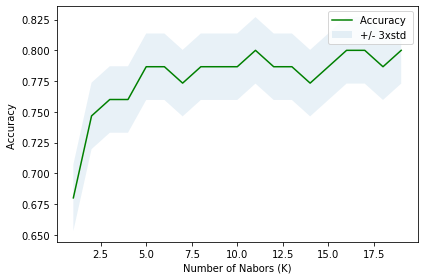

In [21]:
plt.plot(range(1,Ks),mean_acc2,'g')
plt.fill_between(range(1,Ks),mean_acc2 - 1 * std_acc2,mean_acc2 + 1 * std_acc2, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

**Predict and compare results with sklearn**

In [22]:
best_k_knn = mean_acc.argmax()+1
best_k_myknn = mean_acc2.argmax()+1
kfold = KFold(n_splits=10)
kfold.split(X_train)
knn_model_time=[]
knn_accuracy_model = []
myknn_model_time=[]
myknn_accuracy_model=[]

for train_index, test_index in kfold.split(X):
    # Split train-test
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    start = int(round(time.time() * 1000))
    neigh = KNeighborsClassifier(n_neighbors = best_k_knn)
    knn_model = neigh.fit(X_train,y_train)
    knn_accuracy_model.append(accuracy_score(y_test,neigh.predict(X_test),normalize=True)*100)
    time_knn = int(round(time.time() * 1000)) - start
    knn_model_time.append(time_knn)

    start = int(round(time.time() * 1000))
    yhat = knn_predict(X_train, y_train, X_test, k=best_k_myknn)
    myknn_accuracy_model.append(accuracy_score(y_test, yhat)*100)
    time_myknn = int(round(time.time() * 1000)) - start
    myknn_model_time.append(time_myknn)

    diff = [(i / j)*100 for i, j in zip(myknn_model_time,knn_model_time)] 
results_df = pd.DataFrame()
results_df['knn_accuracy_model'] = knn_accuracy_model
results_df['knn_model_time'] = knn_model_time
results_df['myknn_accuracy_model'] = myknn_accuracy_model
results_df['myknn_model_time'] = myknn_model_time
results_df['%diff'] = diff
results_df

,knn_accuracy_model,knn_model_time,myknn_accuracy_model,myknn_model_time,%diff
0,10.000000,8,10.000000,7546,94325.000000
1,16.666667,6,16.666667,6467,107783.333333
2,53.333333,6,53.333333,6318,105300.000000
3,76.666667,6,76.666667,7027,117116.666667
4,76.666667,5,76.666667,6188,123760.000000
5,90.000000,6,90.000000,6088,101466.666667
6,60.000000,6,60.000000,6376,106266.666667
7,80.000000,6,80.000000,6276,104600.000000
8,86.666667,6,86.666667,5897,98283.333333
9,86.206897,7,86.206897,6970,99571.428571
